<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></span></li></ul></li><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1</span> Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2</span> Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3</span> Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4</span> Testing</a></span><ul class="toc-item"><li><span><a href="#Conclusions:" data-toc-modified-id="Conclusions:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span> Conclusions:</a></span></li>

# Forecasting taxi orders

A company has collected historical data on taxi orders at airports. To attract more drivers during peak load, we need to predict the number of taxi orders for the next hour. Wew build a model for this kind of prediction.

The value of the *RMSE* metric in the test sample should be no more than 48.

We need to:

1. Download the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


#### Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'C:\Users\pinos\Downloads\taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
def get_info():
    data.head()
    data.info()
    return data

In [4]:
get_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

We have no missing data.

## Analysis

First we are going to visualize a data frame.

In [6]:
data = data['2018-03-01':'2018-08-31']

In [7]:
data.sort_index(inplace=True)

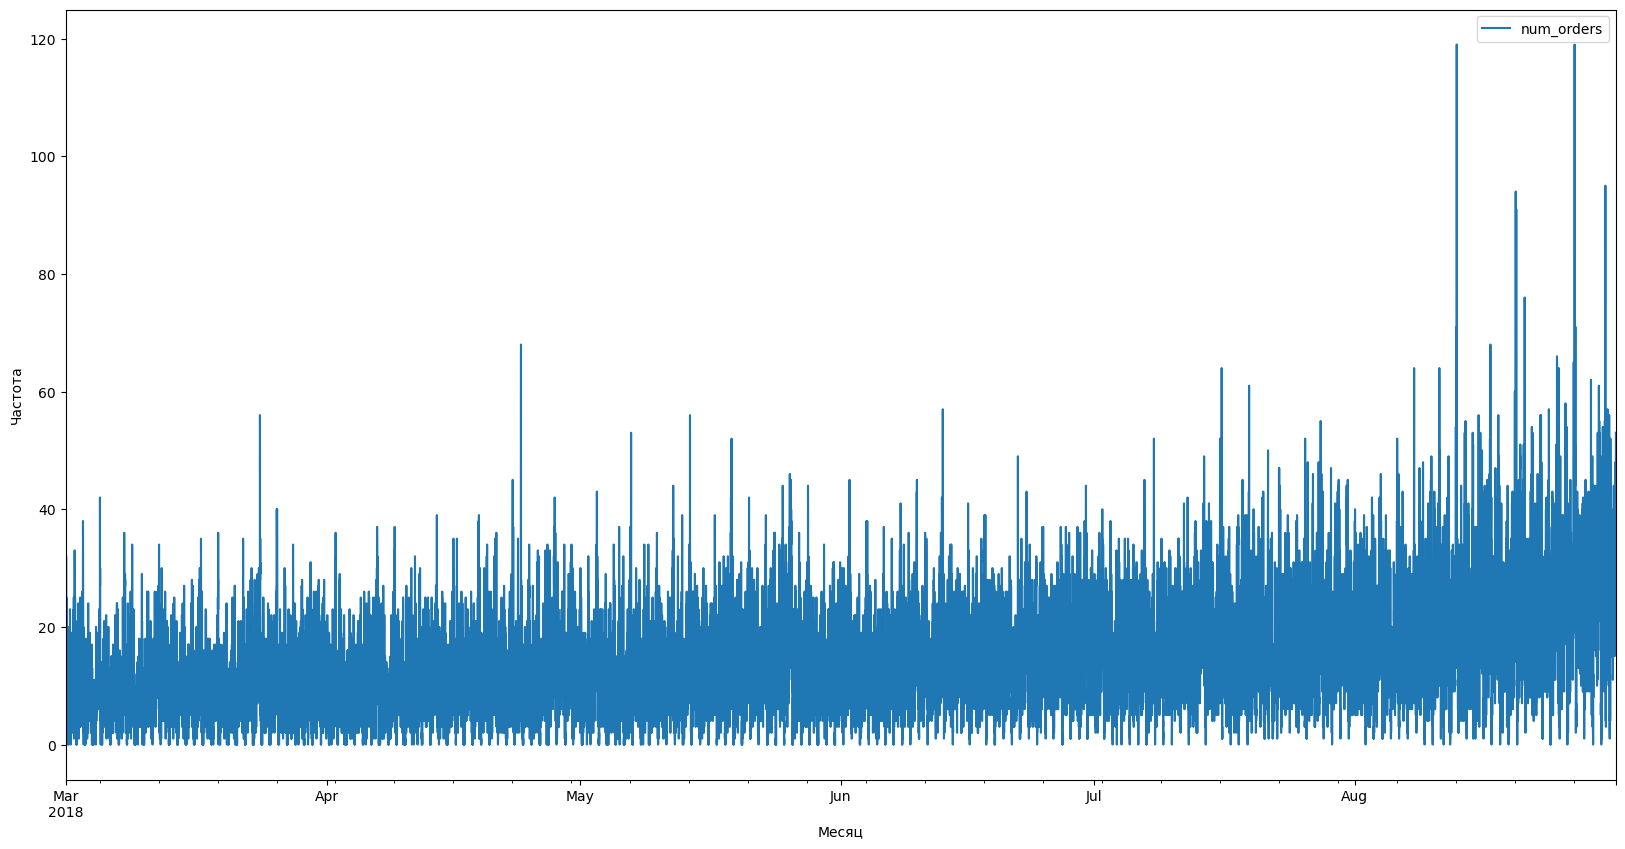

In [8]:
data.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20, 10))
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.show()

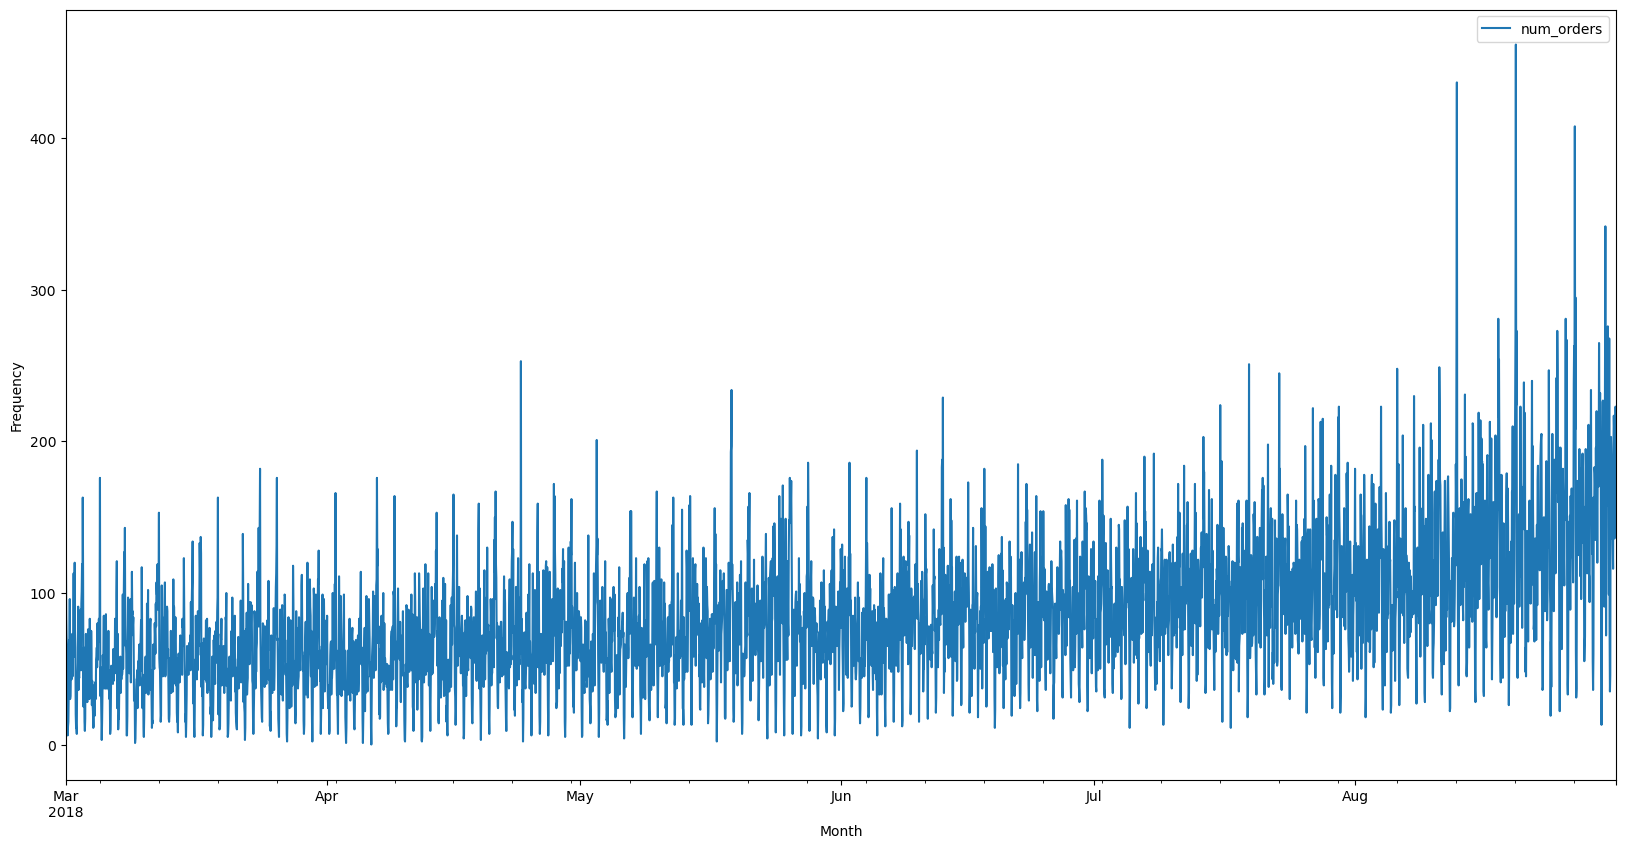

In [9]:
hour=data.resample('1H').sum()
hour.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

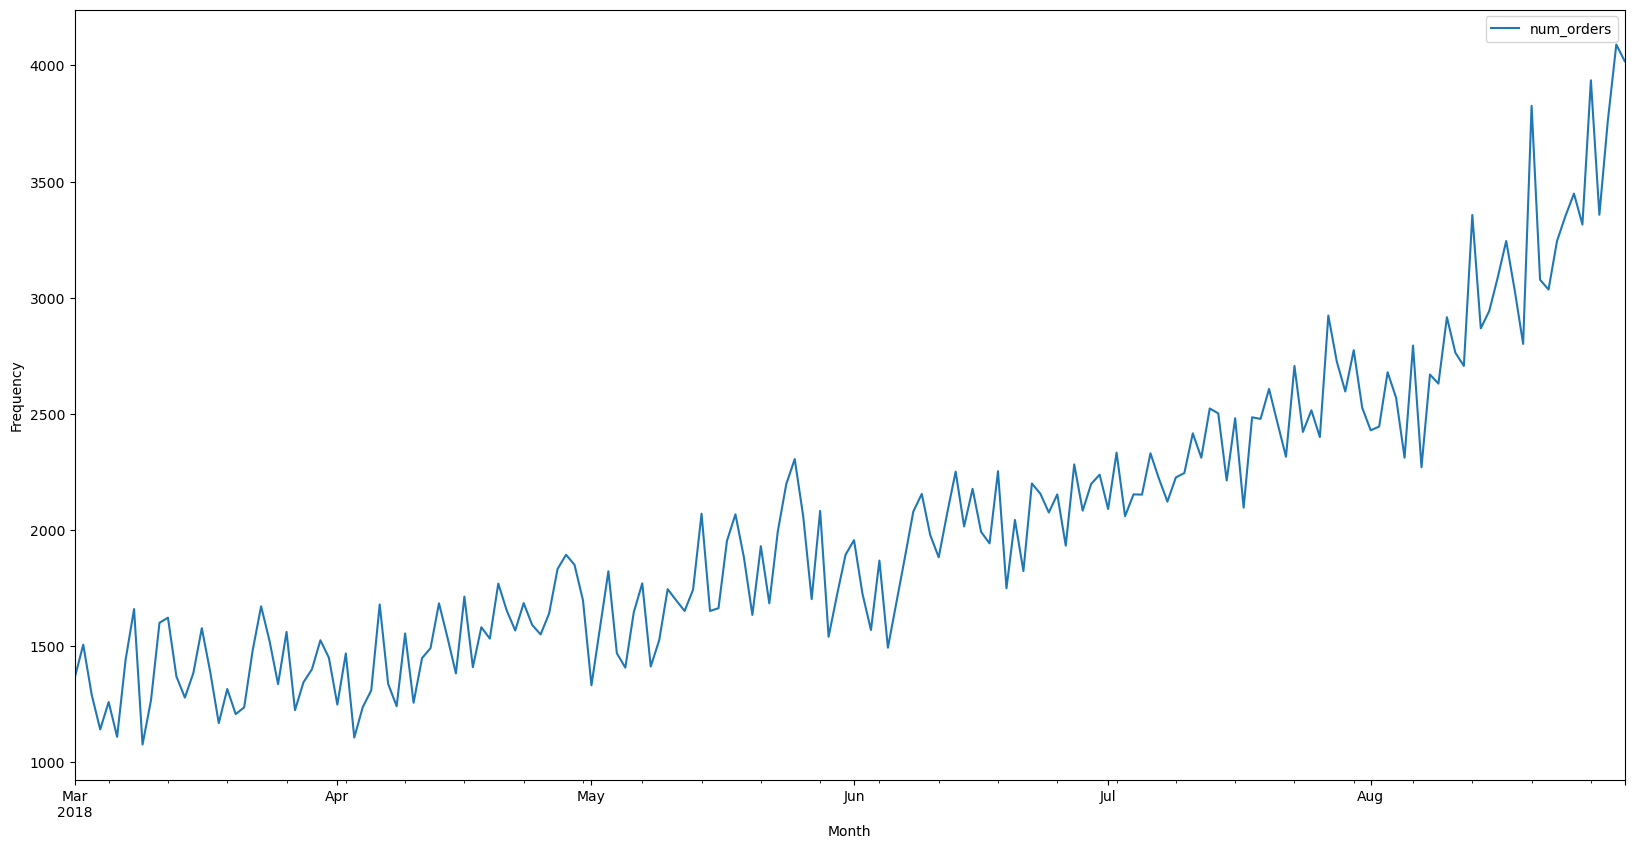

In [10]:
day=data.resample('1D').sum()
day.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

Using the day as a guideline, we see how the chart is taking shape with peaks of growth and decline. We have moved from noise to clarity.

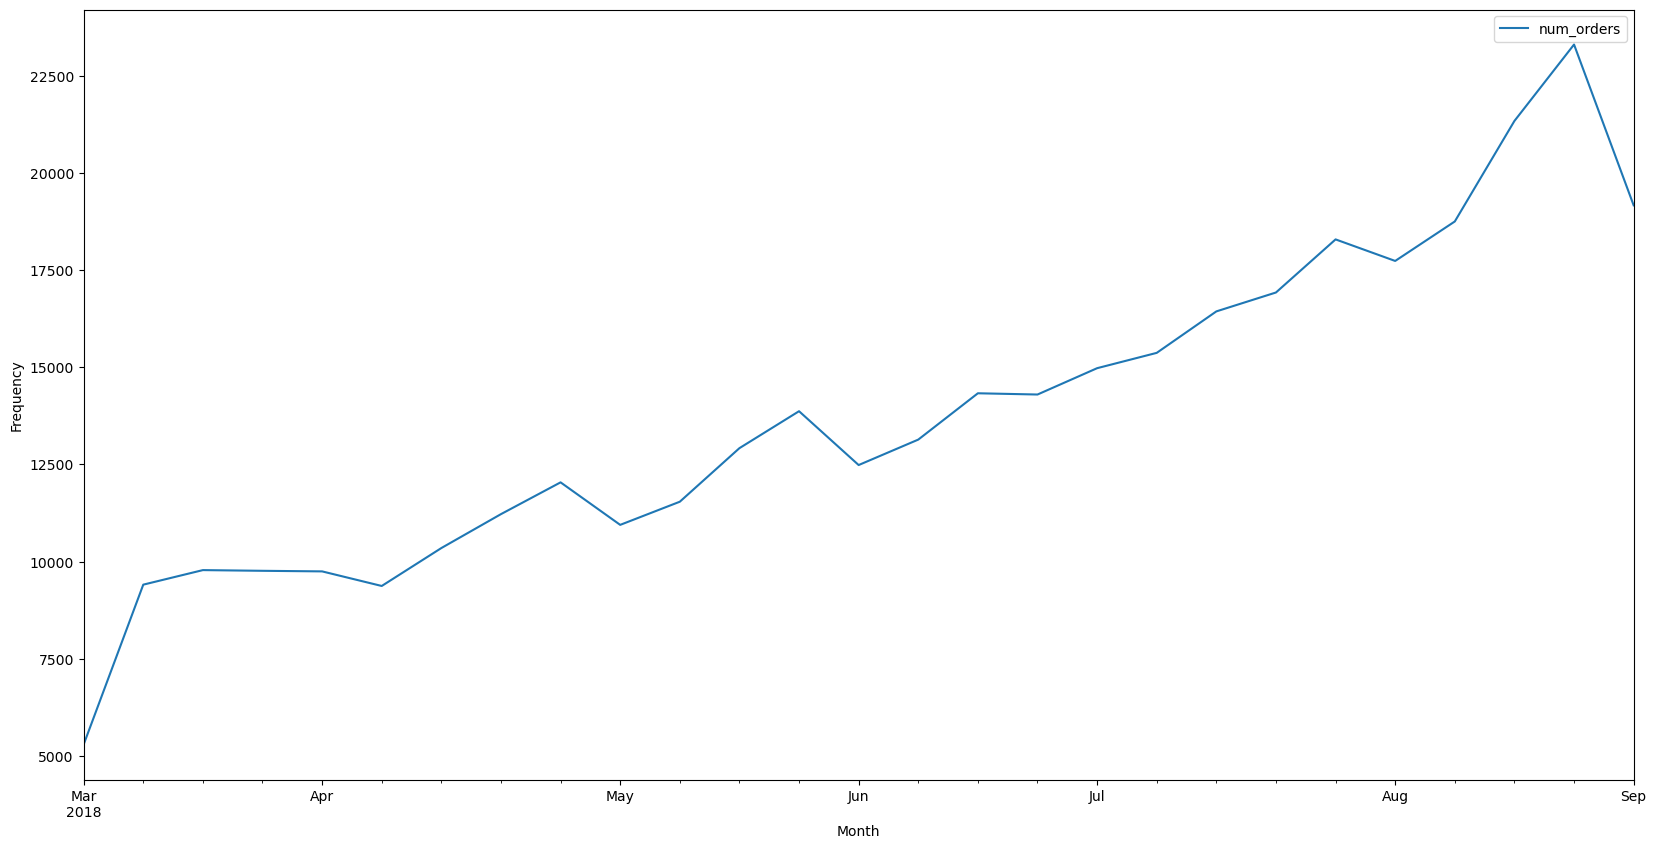

In [11]:
week=data.resample('1W').sum()
week.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

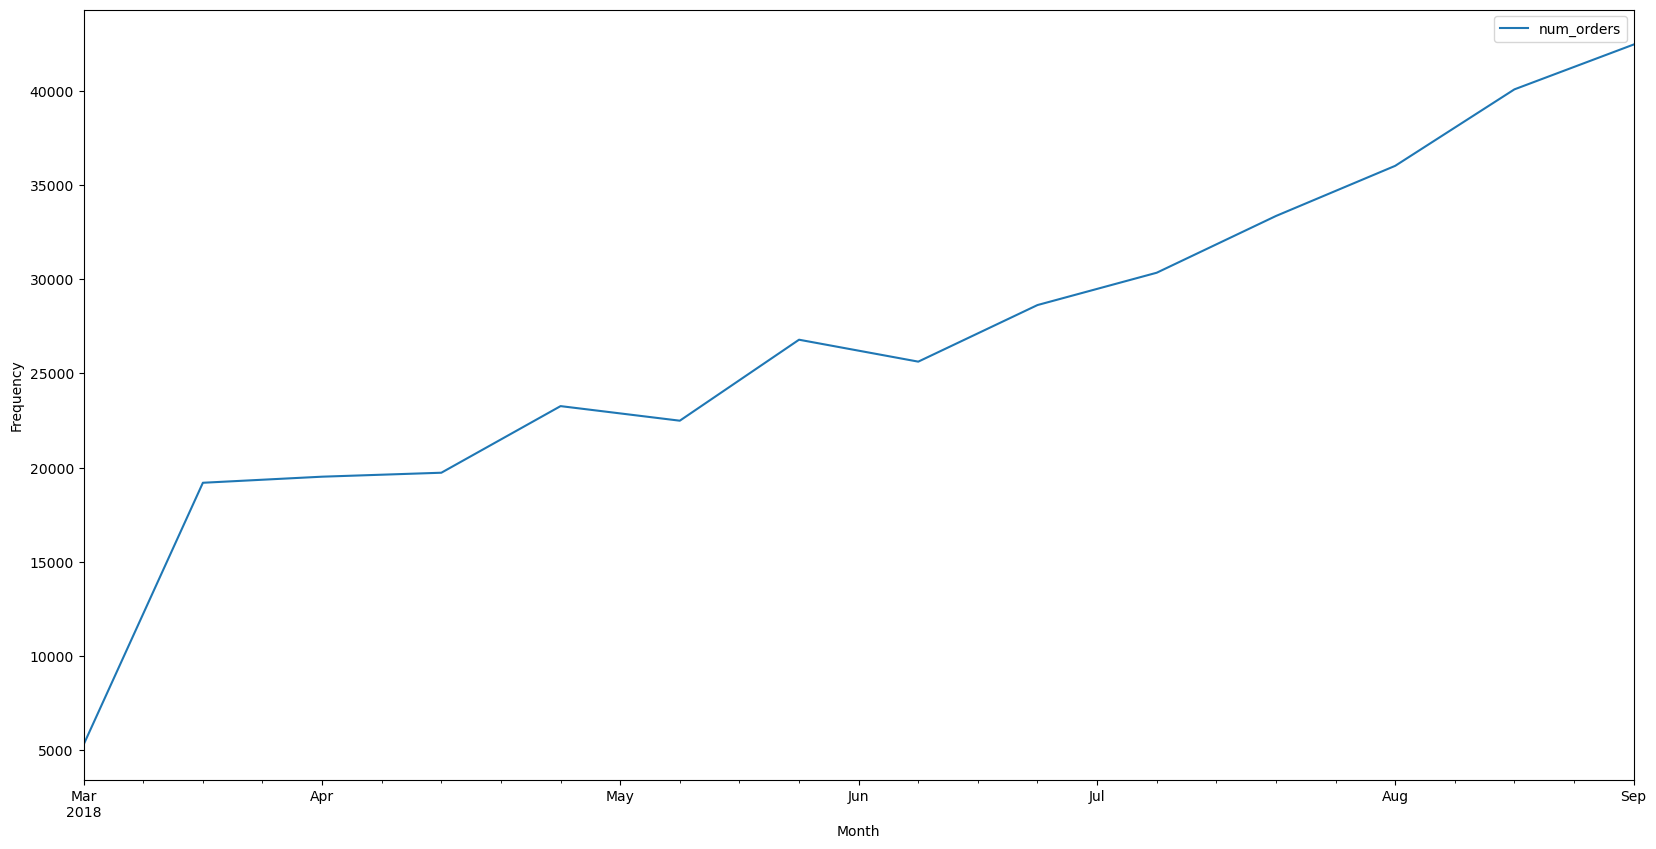

In [12]:
two_week=data.resample('2W').sum()
two_week.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

After one to two weeks, it looks like we may even start to see an upward trend.

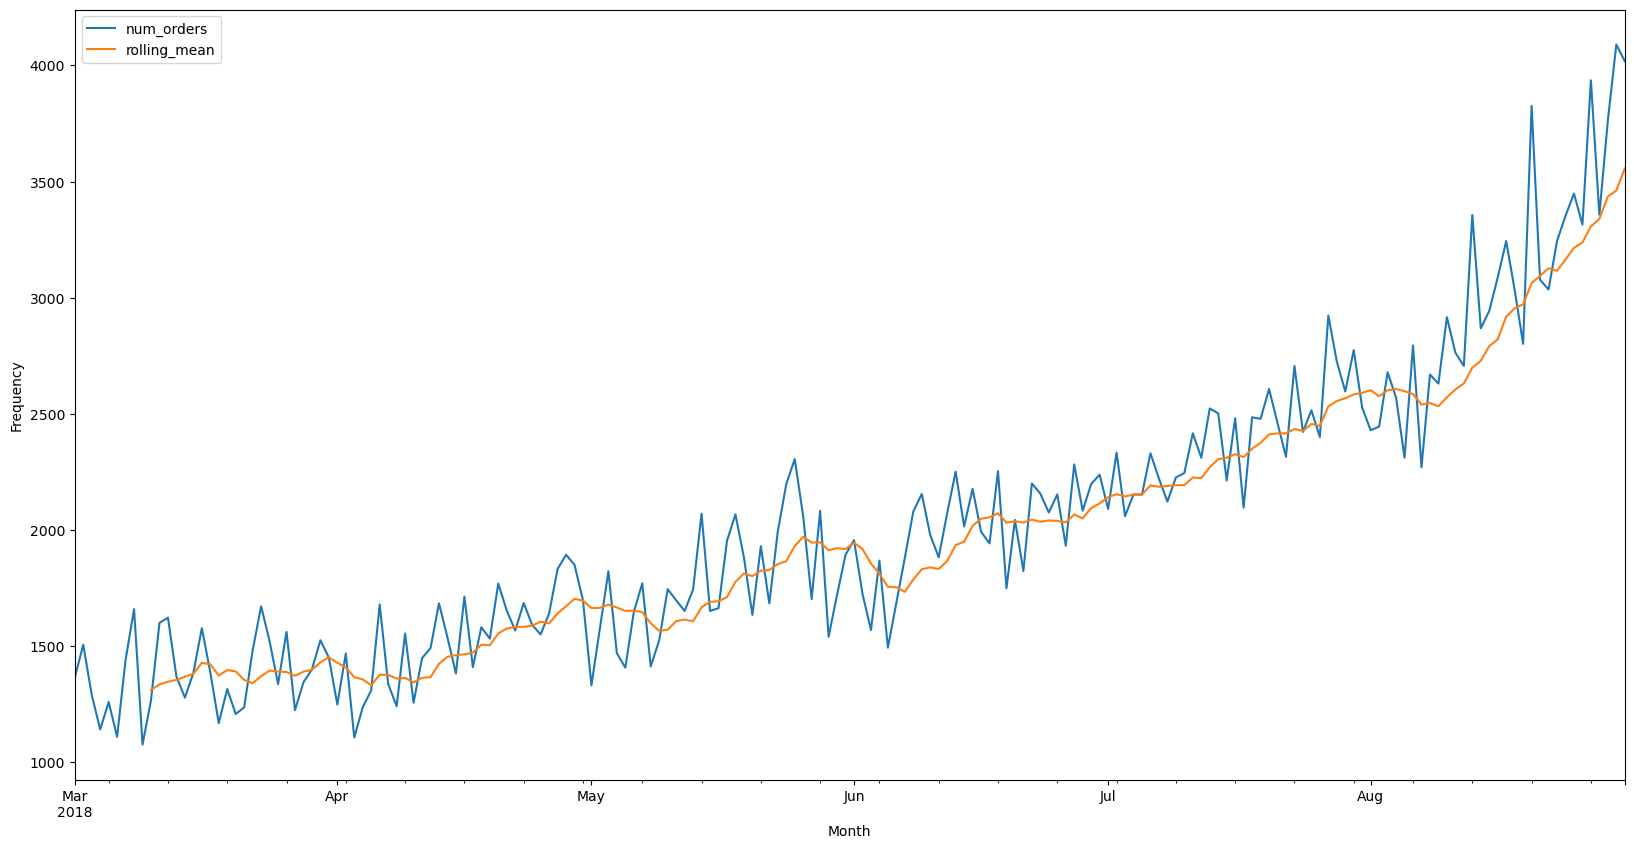

In [13]:
day['rolling_mean'] = day.rolling(10).mean()
day.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

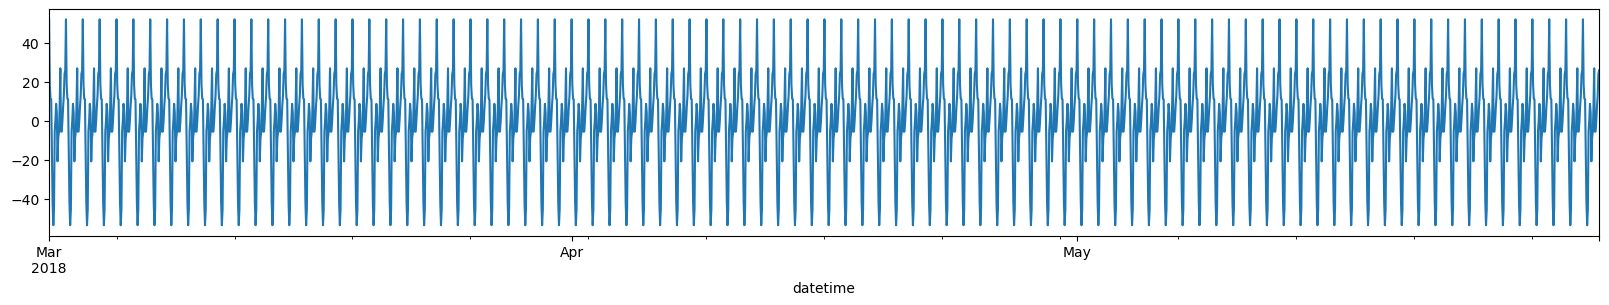

In [14]:
short_interval=data['2018-03-01':'2018-05-31']
short_hour=short_interval.resample('1H').sum()
decomposed = seasonal_decompose(short_hour)
plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-08-31'].plot(ax=plt.gca())
plt.show()

Thus, it seems that we cannot single out any clear trend.

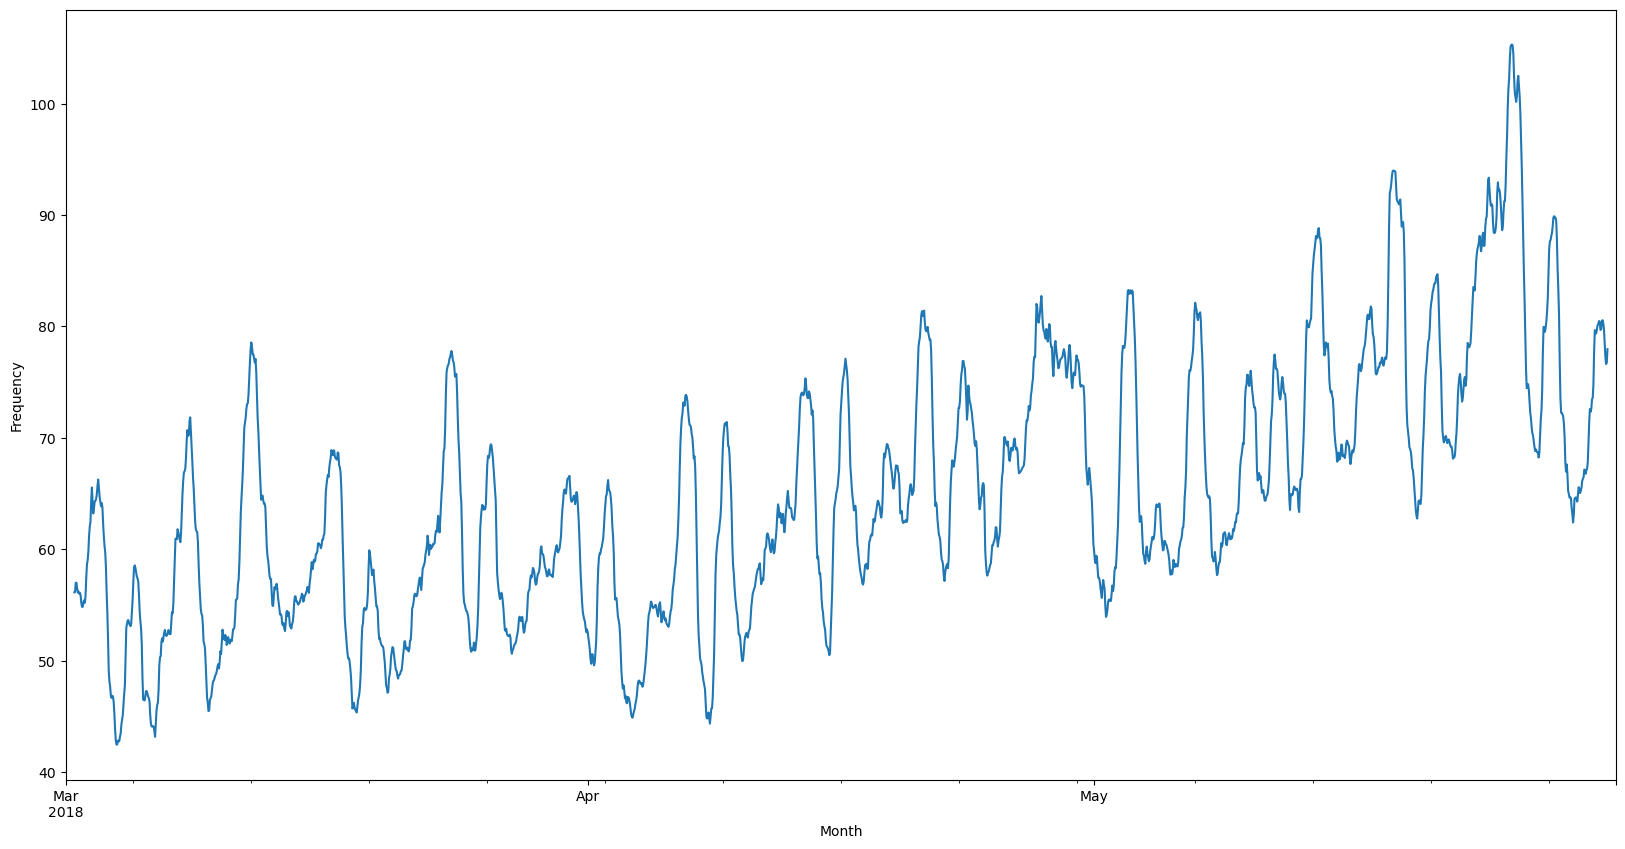

In [15]:
decomposed = seasonal_decompose(short_hour)
decomposed.trend.plot(figsize=(20,10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

Now if we see that there are clear trends in orders during peak hours and during other quieter periods.

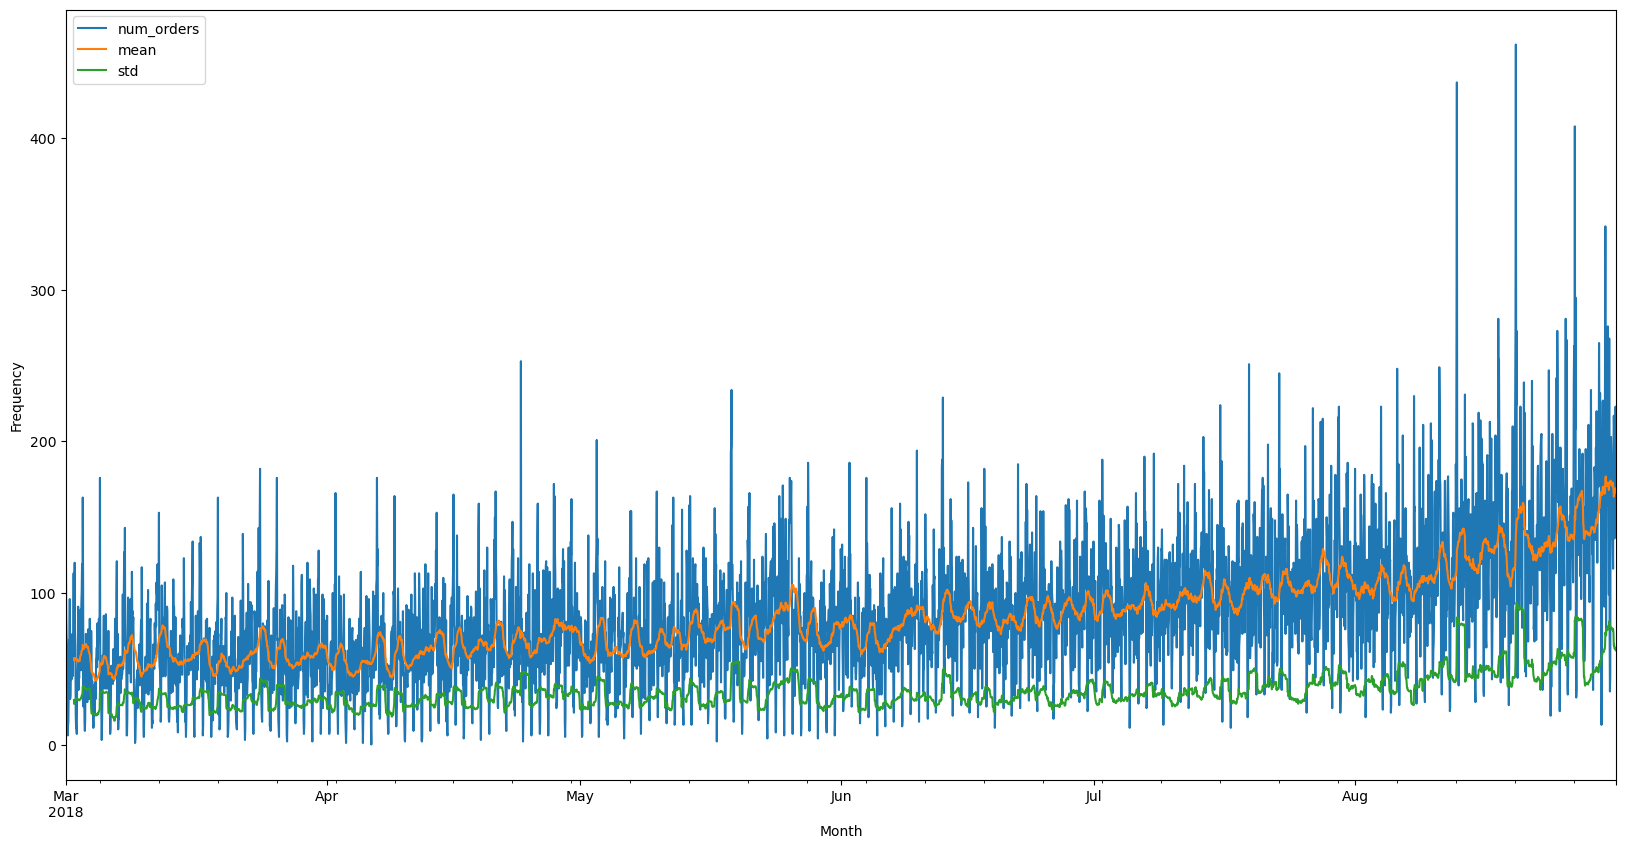

In [16]:
hour['mean'] = hour['num_orders'].rolling(24).mean()
hour['std'] = hour['num_orders'].rolling(24).std()
hour.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20,10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

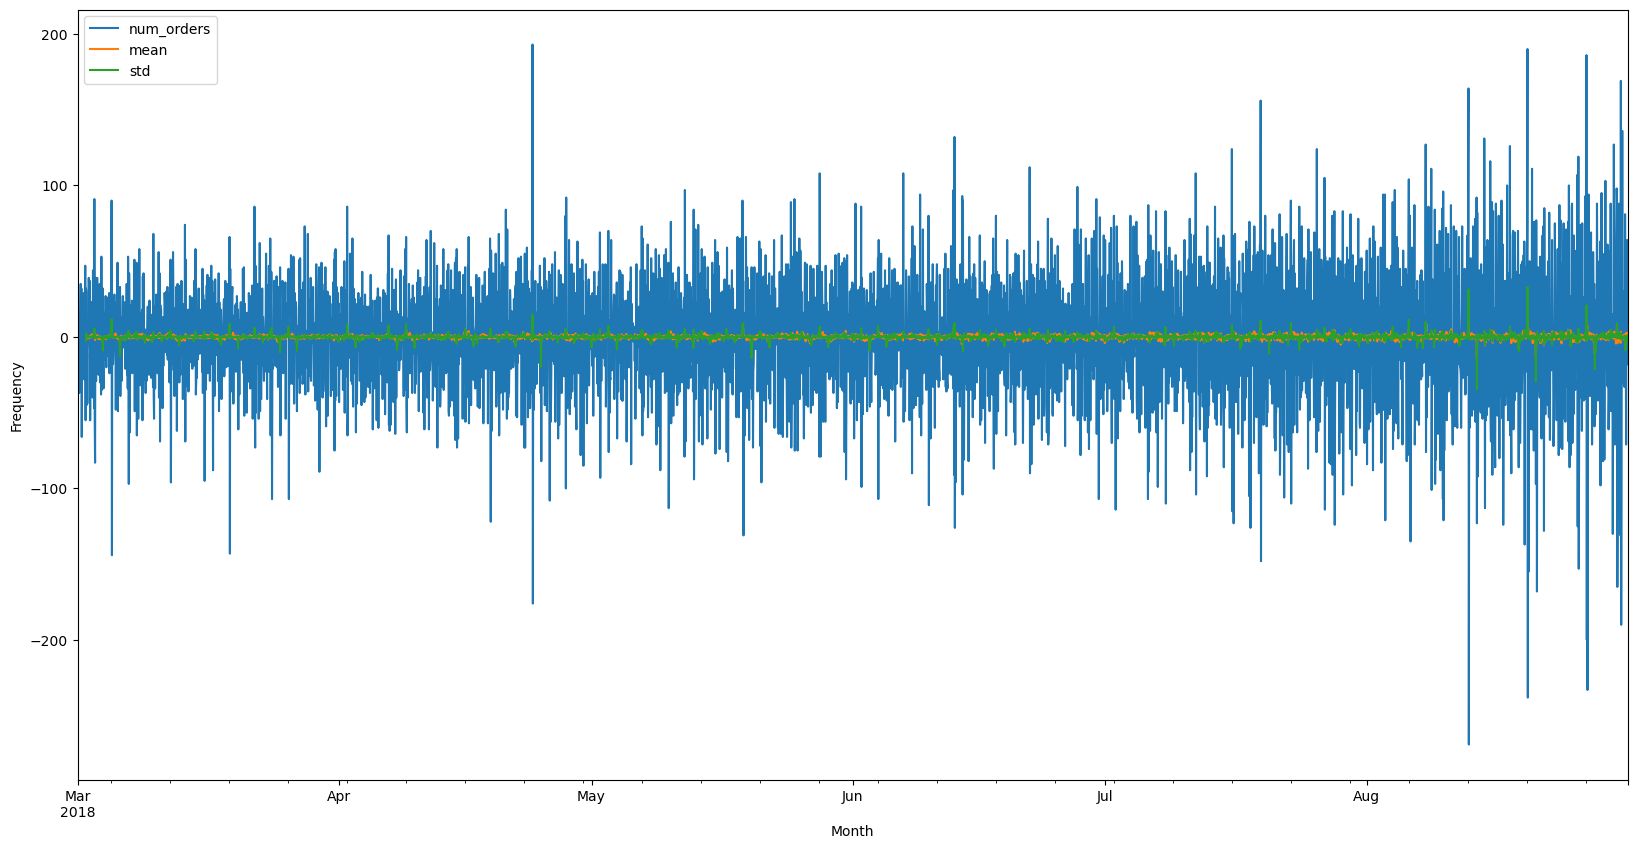

In [17]:
hour -= hour.shift()
hour.plot(scalex='autoscale_view', scaley='autoscale_view', figsize=(20,10))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

The latest charts show a steady trend, as the mean and standard deviation show us. We can say that this is ideal for forecasting.

## Training

We have created a function to handle the days of the week and month.

We choose as a 24-hour lag what we are interested in, and rolling_mean_size, doubled by 48

In [18]:
data=data.resample('1H').sum()

In [19]:
max_lag=24
rolling_mean_size = 48

In [20]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['hour']= data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)
    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [21]:
make_features(data, 'hour', max_lag, rolling_mean_size)

In [22]:
get_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   hour          4416 non-null   int64  
 2   lag_1         4415 non-null   float64
 3   lag_2         4414 non-null   float64
 4   lag_3         4413 non-null   float64
 5   lag_4         4412 non-null   float64
 6   lag_5         4411 non-null   float64
 7   lag_6         4410 non-null   float64
 8   lag_7         4409 non-null   float64
 9   lag_8         4408 non-null   float64
 10  lag_9         4407 non-null   float64
 11  lag_10        4406 non-null   float64
 12  lag_11        4405 non-null   float64
 13  lag_12        4404 non-null   float64
 14  lag_13        4403 non-null   float64
 15  lag_14        4402 non-null   float64
 16  lag_15        4401 non-null   float64
 17  lag_16        4400 non-null

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,18.0,17.0,16.0,15.0,14.0,13.0,12.0,11.0,...,3.0,2.0,1.0,0.0,23.0,22.0,21.0,20.0,19.0,11.5
2018-08-31 20:00:00,154,20,19.0,18.0,17.0,16.0,15.0,14.0,13.0,12.0,...,4.0,3.0,2.0,1.0,0.0,23.0,22.0,21.0,20.0,11.5
2018-08-31 21:00:00,159,21,20.0,19.0,18.0,17.0,16.0,15.0,14.0,13.0,...,5.0,4.0,3.0,2.0,1.0,0.0,23.0,22.0,21.0,11.5


Let's start splitting the data for training.

In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=42)

In [24]:
test.head()

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,14,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,...,22.0,21.0,20.0,19.0,18.0,17.0,16.0,15.0,14.0,11.5
2018-08-13 15:00:00,175,15,14.0,13.0,12.0,11.0,10.0,9.0,8.0,7.0,...,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0,15.0,11.5
2018-08-13 16:00:00,144,16,15.0,14.0,13.0,12.0,11.0,10.0,9.0,8.0,...,0.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0,11.5
2018-08-13 17:00:00,152,17,16.0,15.0,14.0,13.0,12.0,11.0,10.0,9.0,...,1.0,0.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,11.5
2018-08-13 18:00:00,104,18,17.0,16.0,15.0,14.0,13.0,12.0,11.0,10.0,...,2.0,1.0,0.0,23.0,22.0,21.0,20.0,19.0,18.0,11.5


<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано корректно.
</div>

In [25]:
test.shape

(442, 27)

In [26]:
train.head() 

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
train.shape

(3974, 27)

In [28]:
train=train.dropna()

In [29]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size = 0.1, random_state=42)

We will use GridSearch to search for parameters, and the first model we are going to try out is LogisticRegression().

In [31]:
tsp = TimeSeriesSplit(n_splits=8)

In [32]:
param_grid =  {'bootstrap': [True], 
               'max_depth': [5, 10, None], 
               'max_features': ['auto', 'log2'], 
               'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

In [33]:
model = RandomForestRegressor(random_state = 1)
grid = GridSearchCV(model,
                    param_grid = param_grid, 
                    scoring='neg_mean_squared_error', 
                    n_jobs=-1, 
                    cv=tsp, 
                    verbose=0)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]},
             scoring='neg_mean_squared_error')

In [34]:
%%time
cross_val_random = (cross_val_score(grid, 
                             X_train, 
                             y_train, 
                             cv=tsp, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE RandomForestRegressor:', cross_val_random)


RMSE RandomForestRegressor: 30.366574700587083
CPU times: total: 2.91 s
Wall time: 23 s


The resulting RMSE is not bad, we see that it is lower than the 48 parameters set by the client. In the future, we will see that other models work this way.

In the last two models that we are going to test, we will use the RandomizedSearch.

In [35]:
model_lgbm = LGBMRegressor(random_state=6)

In [36]:
param_grid = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], 
    'boosting_type' : ['gbdt', 'dart'], 
    'max_bin':[255, 510], 
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [37]:
search_cv_lgbm = RandomizedSearchCV(model_lgbm, 
                                    param_grid, 
                                    n_iter=10, 
                                    cv=tsp,
                                    scoring='neg_mean_squared_error')

In [38]:
search_cv_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 397, number of used features: 25
[LightGBM] [Info] Start training from score 78.682620
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 789, number of used features: 25
[LightGBM] [Info] Start training from score 77.039290
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1181, number of used features: 25
[LightGBM] [Info] Start 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=LGBMRegressor(random_state=6),
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'colsample_bytree': [0.64, 0.65, 0.66],
                                        'learning_rate': [0.005, 0.01],
                                        'max_bin': [255, 510],
                                        'n_estimators': [8, 16, 24],
                                        'num_leaves': [6, 8, 12, 16],
                                        'reg_alpha': [1, 1.2],
                                        'reg_lambda': [1, 1.2, 1.4],
                                        'subsample': [0.7, 0.75]},
                   scoring='neg_mean_squared_error')

In [39]:
%%time
cross_val_lgbm = (cross_val_score(search_cv_lgbm, 
                             X_train, 
                             y_train, 
                             cv=tsp, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE LGBM:', cross_val_lgbm)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 25
[LightGBM] [Info] Start training from score 80.622222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

The Lightboost Regressor model still works worse than the previous one, now we are going to test the third model.

In [40]:
model_cb = CatBoostRegressor(random_state=3,silent=True)

In [41]:
param_grid_cb = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
                 }

In [42]:
search_cv_cb = RandomizedSearchCV(model_cb, 
                                  param_grid_cb, 
                                  cv=tsp, 
                                  n_iter=10, 
                                  scoring='neg_mean_squared_error')

In [43]:
%%time
cross_val_cb = (cross_val_score(search_cv_cb, 
                             X_train, 
                             y_train, 
                             cv=tsp, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE CatBoost cross_val :', cross_val_cb)


RMSE CatBoost cross_val : 30.18441866310179
CPU times: total: 4min 36s
Wall time: 1min 31s


This model, apparently, is the one that we wanted to bring to the testing stage.

## Testing the model

The model that gives the best results is the CatBoost model that we are going to test.

In [44]:
search_cv_cb.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001DA74AD5110>,
                   param_distributions={'depth': [6, 8, 10],
                                        'iterations': [30, 50, 100],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   scoring='neg_mean_squared_error')

In [45]:
pred_cb=search_cv_cb.predict(X_test)

In [46]:
%%time
MSE = np.square(np.subtract(y_test, pred_cb)).mean() 
RMSE_cb = math.sqrt(MSE) 
print("RMSE CatBoost at the testing stage: ", RMSE_cb)

RMSE CatBoost at the testing stage:  31.473821115068468
CPU times: total: 0 ns
Wall time: 998 µs


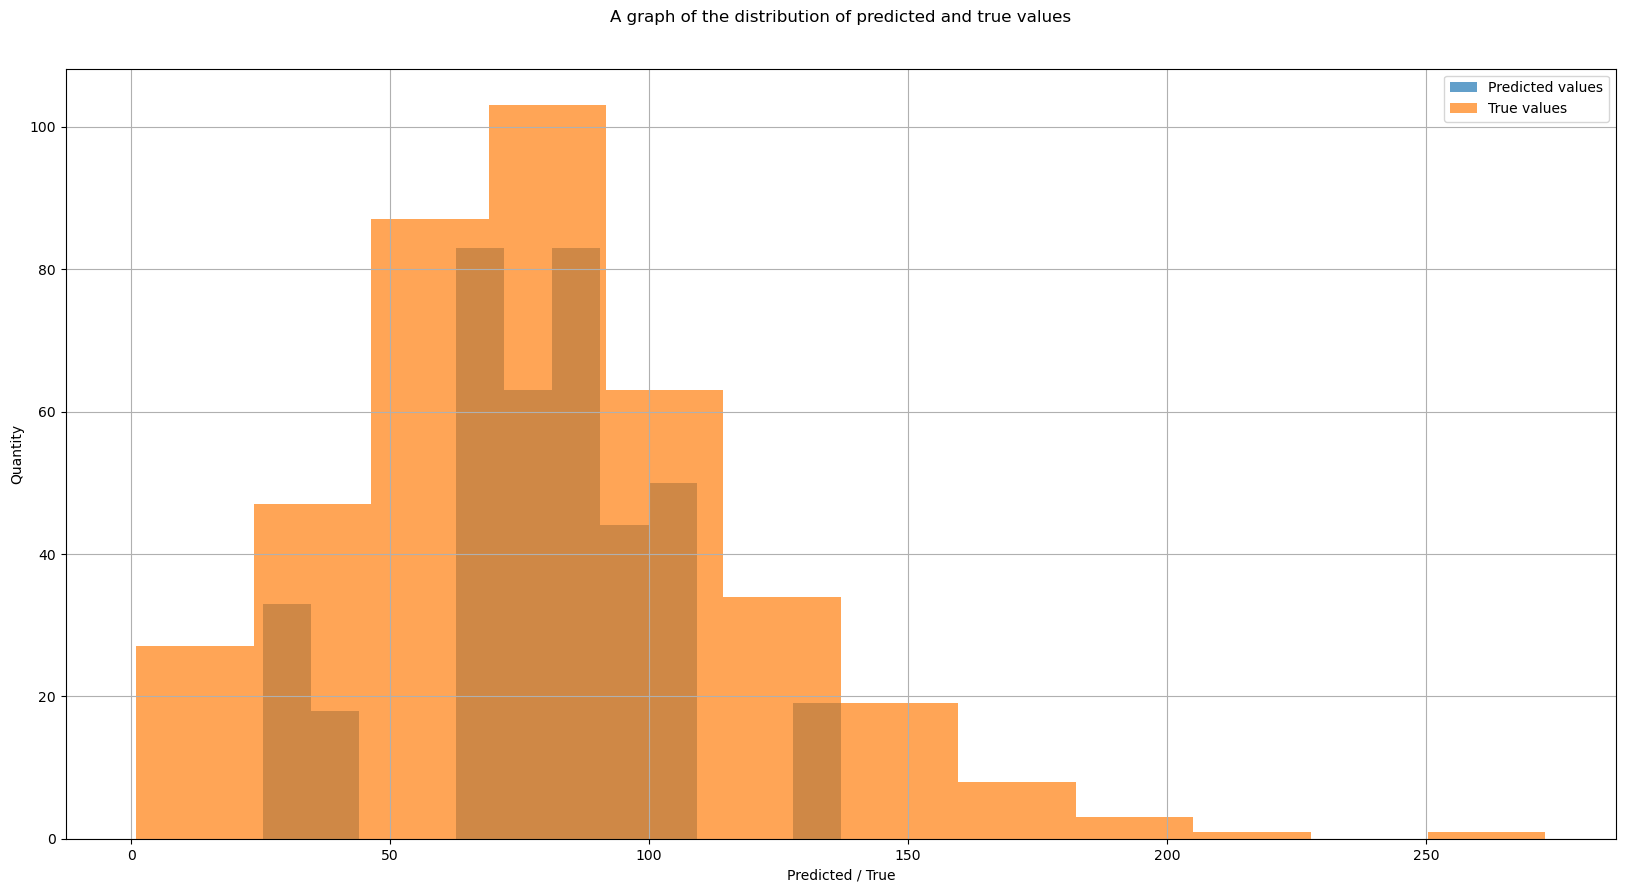

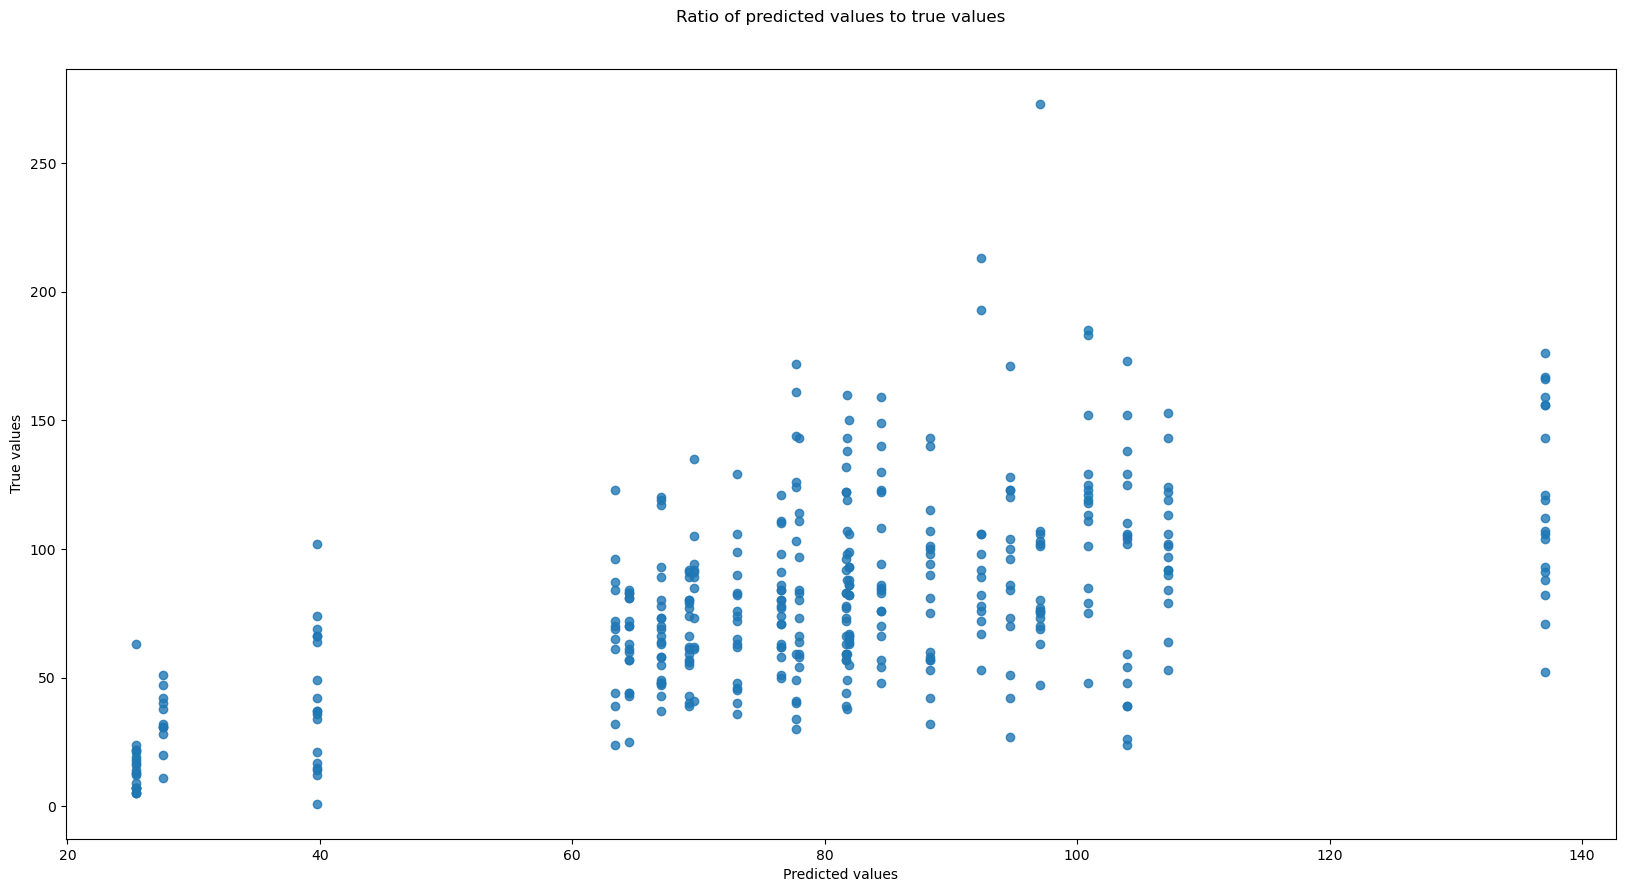

In [47]:
plt.figure(figsize=(20, 10))
pd.Series(pred_cb).hist(bins=12, alpha=0.7)
pd.Series(y_test).hist(bins=12, alpha=0.7)
plt.legend(['Predicted values', 'True values'])
plt.title('A graph of the distribution of predicted and true values', y=1.05)
plt.xlabel('Predicted / True')
plt.ylabel('Quantity')
plt.subplot()   
plt.figure(figsize=(20, 10))
plt.plot(pred_cb, y_test,'o', alpha=0.8)
plt.title('Ratio of predicted values to true values', y=1.05)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.show()

The graph shows that forecasting tends to reduce the number of taxi orders compared to the verification data.
On the other hand, we see that the relationship between the predicted data and the validation data is positive.

### Conclusions:
All the models we used work well, and the difference between them, as we can see from the estimates obtained, is minimal. However, with a small difference, the model that works best is the CatBoost model. This is a model that we recommend to the client to predict taxi orders by hour and, thus, optimize the distribution of taxi drivers by zones.